In [63]:
## CHEK PLOTS
#LABELS
#UNITS
# NO TITLES
#

# Earthquake Data Analysis

### Description

The catalog includes the magnitude, time of occurrence (s), and 3D coordinates (m) of earthquakes in about 20 years of recording in South California. Coordinates were converted from latitude, longitude, and depth of events in a seismic catalog. Magnitudes should be within the range $[0,8]$.

* **Waiting time (t)**: time interval between an event and the next one in the sequence.
* **Distance (r)**: Eucledian 3D distance between events. (each 3D set of coordinates refers to the hypocenter, i.e. the point triggering the slip in a fault that forms the earthquake)


### Assignments

1. Deduce what is the variable in each column of the catalog.
2. Visualize the process in space and/or time with suitable time series and/or 3D visualizations of the hypocenters. For instance, plot a space variable (a single coordinate or a nice linear combination of coordinates) as a function of time.
3. Compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$.
4. Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude m or above. Also here make a clever choice for the bin sizes and try several values of $m$.
5. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. (In this statistics, if the following event is farther than $R$, skip the $t$ and go to the next pair)
6. Eventually note if, from the analysis of the previous points, there emerges a scaling picture. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 5 is considered) on a single curve?

### Datasets

* column 1: index of the event
* column 2: index of the previous event that triggered it (defined with a given algorithm), -1 if no ancestor is found
* column 3: time (seconds) from 0:00 of Jan.1st, 1982
* column 4: magnitude
* columns 5, 6, and 7: 3D coordinates (meters) of the earthquake hypocenter, i.e. of the point from where it started. These Euclidean coordinates are derived from latitude, longitude and depth.

Joining each event to that with the index of the second column (if not -1), there emerges a set of causal trees.


### Contact
* Marco Baiesi <marco.baiesi@unipd.it>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import datetime
#import geopandas as pd
import datetime as dt
import seaborn as sns
from scipy import optimize
from scipy import stats
import copy
%matplotlib notebook

# EXERCICE 1

EXPLAIN

In [184]:
header=['ID', 'trigger', 'time', 'Magnitude', 'X', 'Y','Z']
df=pd.read_csv('SouthCalifornia-1982-2011_Physics-of-Data.dat', sep=' ', names=header, index_col=0).sort_values(by='time')
df

,trigger,time,Magnitude,X,Y,Z
ID,,,,,,
0,-1,0.000000e+00,2.71,-2571956,-4627162,3520602
1,0,3.650139e+04,2.12,-2363740,-4787011,3461373
2,0,3.748828e+04,2.33,-2363746,-4786942,3461232
3,0,4.798252e+04,2.57,-2475085,-4664024,3548479
4,0,6.026857e+04,2.98,-2238642,-4839098,3469546
...,...,...,...,...,...,...
110266,-1,9.304996e+08,2.60,-2668492,-4335735,3810743
110267,-1,9.305115e+08,2.02,-2297480,-4823870,3445285
110268,-1,9.305318e+08,2.00,-2404797,-4441247,3868121


 # EXERCICE 2

In [190]:
time1 = datetime.datetime(1982, 1, 1, 0, 0, 0)
time2 = datetime.datetime(1970, 1, 1, 0, 0, 0)

delta = time1 - time2

total_seconds = delta.total_seconds()

#df["timestamp"] = pd.to_datetime(df["time"], unit="s").dt.strftime("%Y-%m-%d %H:%M:%S")
df["timestamp"] = pd.to_datetime(df["time"] + total_seconds, unit="s")
df["year"] = pd.to_datetime(df["timestamp"]).dt.year
df["month"] = pd.to_datetime(df["timestamp"]).dt.month
df["day"] = pd.to_datetime(df["timestamp"]).dt.day

Text(0, 0.5, 'Max Magnitude')

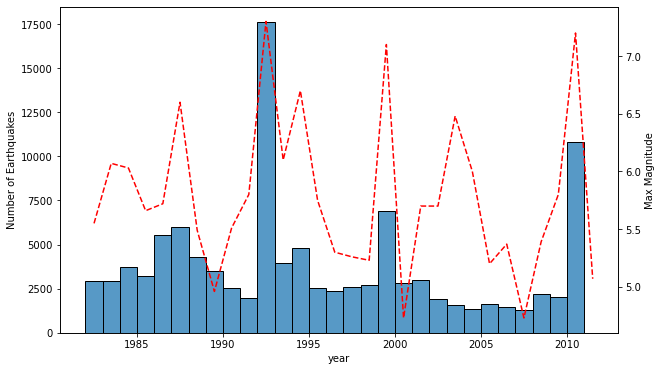

In [191]:
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 6))

grouped_data = df.groupby("year").max()

sns.histplot(df["year"], binwidth=1 )

bin_edges = np.arange(df["year"].min(), df["year"].max() + 2, 1)

bin_centers = (bin_edges[:-1] + bin_edges[1:])*0.5

ax2 = plt.twinx()

sns.lineplot(x=bin_centers, y="Magnitude", data = grouped_data, ax=ax2, color='red')

ax2.lines[0].set_linestyle("--")

ax.set_ylabel("Number of Earthquakes")
ax2.set_ylabel("Max Magnitude")

##### ADD LEGEND

EXPLAIN PREVIOUS PLOT

In [192]:
def cartesian_to_geographic(x,y,z):
    lat=np.arctan(z/np.sqrt(x**2+y**2))
    
    long=np.arctan(y/x)
    long=long-np.pi #x and y are <0
    Earth_radius=6.371e3
    h=-1*(Earth_radius-np.sqrt(x**2+y**2+z**2)*1e-3) ## in km
    return(lat,long,h)

In [193]:
coords=cartesian_to_geographic(df['X'],df['Y'],df['Z'])
df['Longitude']=coords[0]
df['Latitude']=coords[1]
df['Depth']=coords[2]
df['Hypocenters'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)
df
## CAN BE CHANGED WITH THE LIBRARY

,trigger,time,Magnitude,X,Y,Z,timestamp,year,month,day,Longitude,Latitude,Depth,Hypocenters
ID,,,,,,,,,,,,,,
0,-1,0.000000e+00,2.71,-2571956,-4627162,3520602,1982-01-01 00:00:00.000000000,1982,1,1,0.586867,-2.078111,-13.309831,6.357690e+06
1,0,3.650139e+04,2.12,-2363740,-4787011,3461373,1982-01-01 10:08:21.390720000,1982,1,1,0.575210,-2.029457,-8.308420,6.362692e+06
2,0,3.748828e+04,2.33,-2363746,-4786942,3461232,1982-01-01 10:24:48.277440000,1982,1,1,0.575196,-2.029464,-8.434808,6.362565e+06
3,0,4.798252e+04,2.57,-2475085,-4664024,3548479,1982-01-01 13:19:42.516480000,1982,1,1,0.591721,-2.058682,-9.328141,6.361672e+06
4,0,6.026857e+04,2.98,-2238642,-4839098,3469546,1982-01-01 16:44:28.570560000,1982,1,1,0.576884,-2.004092,-9.700062,6.361300e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110266,-1,9.304996e+08,2.60,-2668492,-4335735,3810743,2011-06-27 16:06:08.170560000,2011,6,27,0.642546,-2.122509,-11.659645,6.359340e+06
110267,-1,9.305115e+08,2.02,-2297480,-4823870,3445285,2011-06-27 19:25:04.728000256,2011,6,27,0.572723,-2.015283,-13.474942,6.357525e+06
110268,-1,9.305318e+08,2.00,-2404797,-4441247,3868121,2011-06-28 01:03:15.733440000,2011,6,28,0.653591,-2.067066,-9.389858,6.361610e+06


In [199]:
df['timestamp'].dt.year
#remove columns year,month,day

ID
0         1982
1         1982
2         1982
3         1982
4         1982
          ... 
110266    2011
110267    2011
110268    2011
110269    2011
110270    2011
Name: timestamp, Length: 110271, dtype: int64

In [7]:
#### divide the data in time (not rows)

time_interval=365.2422*24*60*60 #12 months in seconds

N=int(df['time'].iloc[-1]/time_interval)

intervales=np.zeros(N)

for i in range(N):
    j=time_interval*i
    intervales[i]=df['time'][(df['time']>j) & (df['time']<j+time_interval)].index.max()

intervales=np.insert(intervales,0,0) ##add a 0 at the beggining manually
intervales=np.append(intervales,len(df)-1) ##add the last rows manually

<IPython.core.display.Javascript object>


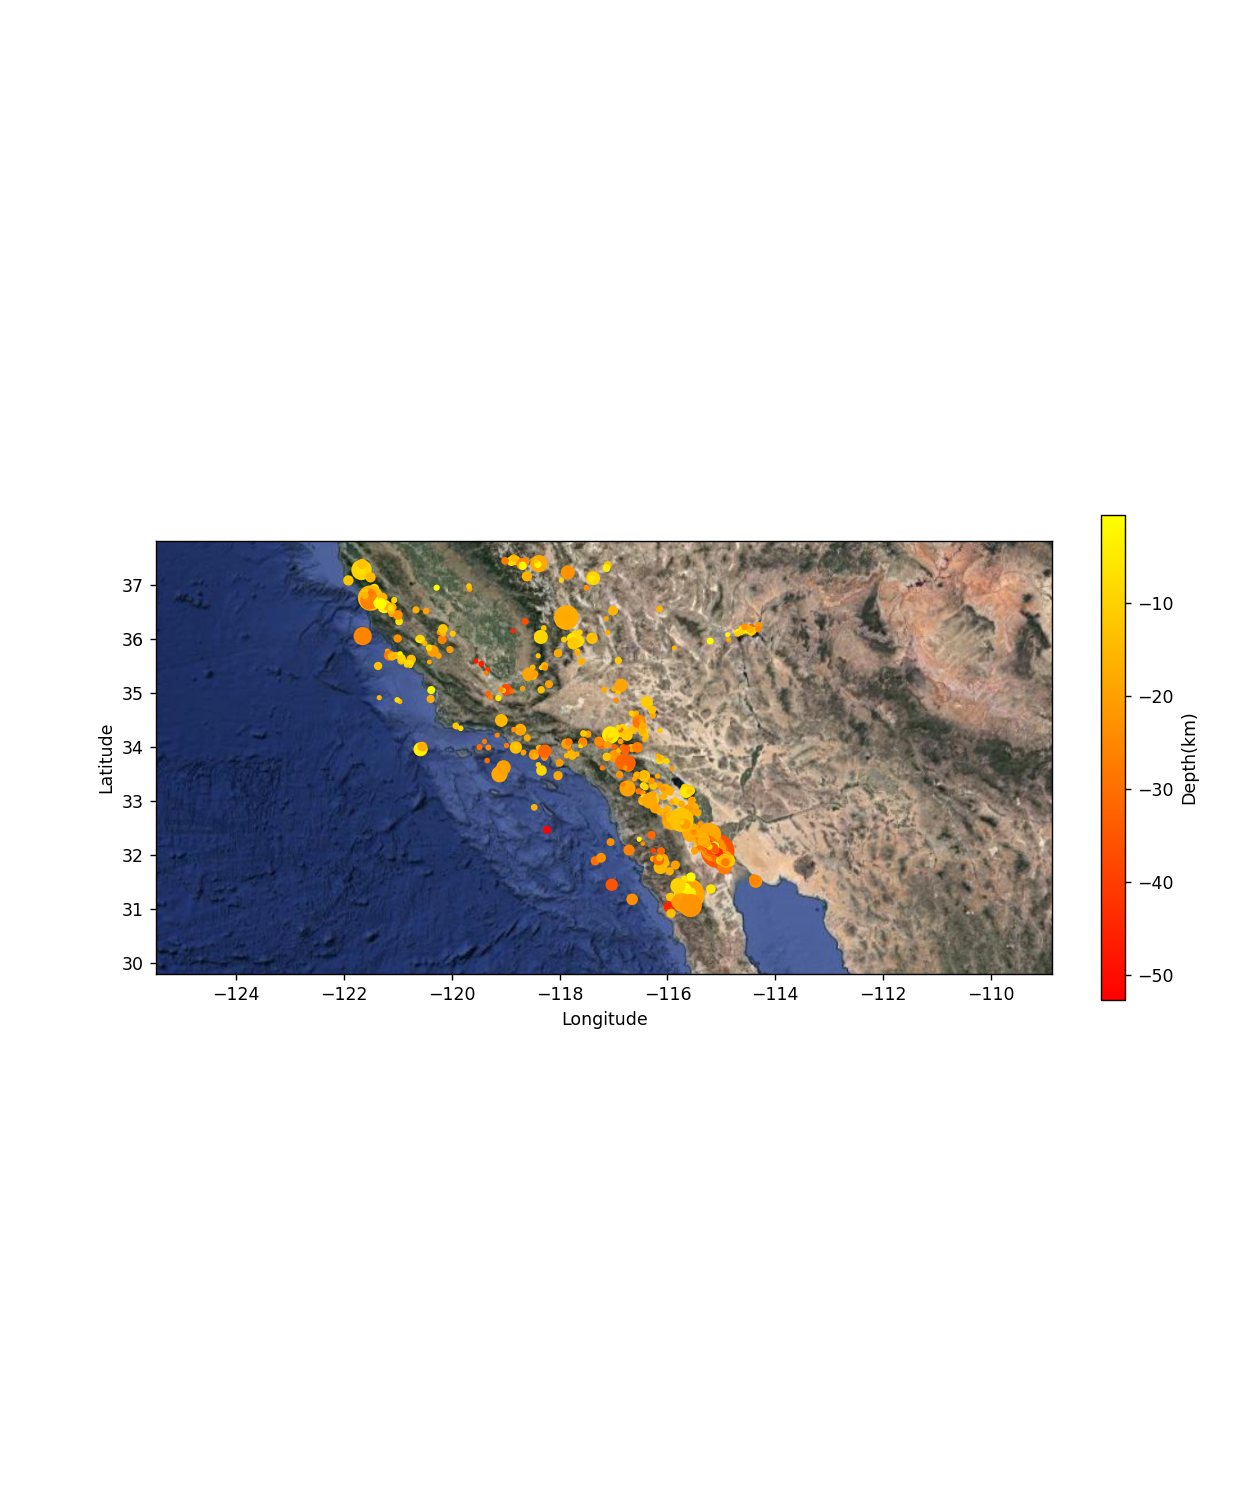

In [22]:
%matplotlib notebook 
#%matplotlib inline
##%motaplotlib notebook for the animation to work

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 1)
x_lim=[-2.19*180/np.pi,-1.90*180/np.pi]
y_lim=[0.52*180/np.pi,0.66*180/np.pi]

fig.set_size_inches(10,12)
background=plt.imread('california.png')
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

plot=ax.scatter(np.zeros(len(df)),np.zeros(len(df)),c=df['Depth'],cmap='autumn') ##'mock' plot for the colorbar
   
cb=fig.colorbar(plot,fraction=0.025,label='Depth(km)') #color bar


speed=200 #####################################

def animate(i):
    j1=int(intervales[i])
    j2=int(intervales[i+1])
    ax.clear()
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    
    data_=df.iloc[j1:j2]
    
    ax.imshow(background,extent=[x_lim[0],x_lim[1],y_lim[0],y_lim[1]]) ##map of california
    ax.scatter(data_['Latitude']*180/np.pi,data_['Longitude']*180/np.pi,c=data_['Depth'],s=data_['Magnitude']**5/10,cmap='autumn')
    #ax.set_title(df['year'][j])
    

ani = FuncAnimation(fig, func=animate, frames=int(len(intervales)-1),
                    interval=speed, repeat=False)
### ADD YEARS, CHECK VELOCITY 
### SHOW ONLY ONE SEQUENCE

EXPLAIN PREVIOUS PLOT

In [9]:
# DISCUSS THIS:
#we would have to differenciate column ID from index column:

header=['ID', 'ID_previous_event', 'time', 'Magnitude', 'X', 'Y','Z']
data=pd.read_csv('SouthCalifornia-1982-2011_Physics-of-Data.dat', sep=' ', names=header)
coords=cartesian_to_geographic(data['X'],data['Y'],data['Z'])
data['longitude']=coords[0]
data['latitude']=coords[1]
data['height']=coords[2]

In [10]:
k=data.groupby('ID_previous_event')['ID'].nunique()
x1=data['Magnitude'][list(k.index)[1:]].values
y1=k.values[1:]

In [11]:
%matplotlib inline
fig=plt.bar(x1,y1, width=0.3)
plt.axvline(x = data['Magnitude'].mean(), color = 'r', label = 'mean magnitude')
plt.xlabel('Magnitude')
plt.ylabel('Number of events the earthquake triggers')
plt.legend(loc='best')
plt.show()
#### mean of all earthquakes??? better mean of earthquakes that trigger other earthquakes

KeyboardInterrupt: 

EXPLAIN PREVIOUS PLOT

In [ ]:
k=data.groupby('ID_previous_event')['ID'].nunique()
x2=data['height'][list(k.index)[1:]].values
y2=k.values[1:]

In [ ]:
%matplotlib inline
plt.bar(x2,y2, width=1)
plt.axvline(x = data['height'].mean(), color = 'r', label = 'mean depth')
plt.xlabel('Depth')
plt.ylabel('Number of events the earthquake triggers')
plt.show()
## MEAN??????

EXPLAIN PREVIOUS PLOT

In [ ]:
###PLOT RELATING DEPTH AND MAGNITUDE???????

## Causal trees:

In [12]:
def trigger_chain(ID,df):
    l = [ID]
    while ID != -1:
        ID = df.iloc[ID][0]
        l.append(ID)
    chain = np.array(l)

    return chain, len(chain)

ID = 15481
print(f"The chain of events is given by {trigger_chain(ID,df)[0]}, with a total of {trigger_chain(ID,df)[1]} ramifications.")

The chain of events is given by [15481 15468 15466 15463  8830    -1], with a total of 6 ramifications.


### Define a function that, given an earthquake, constructs the tree of aftershocks.  

In [14]:
from flatten_dict import flatten

def aftershock_chains(ID,n_branches,df):
    d = {(ID,):None}

    for n in range(n_branches):
        for triggers in list(d.keys()):
            aftershocks = df[df["trigger"] == triggers[-1]].index.to_list()
            d[triggers] = {(j,):None for j in aftershocks}
        d = flatten(d,keep_empty_types=(dict,))

        for triggers in list(d.keys()):
            t = tuple([id for tupl in triggers for id in tupl])
            d[t] = d.pop(triggers)
    return d


ID = 15481 #18722
n_branches = 5

print(f"Given earthquake number {ID} and {n_branches} branches, the chains of aftershocks are (recall that a chain "
      f"that ends with is an inactive chain, while a chain that ends with 'None' can still be active):\n\n{aftershock_chains(ID,n_branches,df)}.")

Given earthquake number 15481 and 5 branches, the chains of aftershocks are (recall that a chain that ends with is an inactive chain, while a chain that ends with 'None' can still be active):

{(15481, 15482, 15495, 15499): {}, (15481, 15482, 15505): {}, (15481, 15482, 15514, 15515): {}, (15481, 15482, 15514, 15527, 15528, 15529): None, (15481, 15482, 15514, 15530, 15532, 15535): None, (15481, 15482, 15514, 15530, 15532, 15669): None, (15481, 15482, 15514, 15544, 15555, 15556): None, (15481, 15482, 15514, 15544, 15609, 15615): None, (15481, 15482, 15514, 15558, 15559): {}, (15481, 15482, 15514, 15561, 15563, 15566): None, (15481, 15482, 15514, 15561, 15563, 15570): None, (15481, 15482, 15514, 15561, 15563, 15572): None, (15481, 15482, 15514, 15561, 15563, 15576): None, (15481, 15482, 15514, 15561, 15563, 15578): None, (15481, 15482, 15514, 15561, 15563, 15585): None, (15481, 15482, 15514, 15561, 15563, 15589): None, (15481, 15482, 15514, 15561, 15563, 15592): None, (15481, 15482, 15514

### Plot chains of aftershocks

In [15]:
def dist(ID0,ID1,data):
    d = np.sqrt((data.iloc[ID0]["X"]-data.iloc[ID1]["X"])**2 + (data.iloc[ID0]["Y"]-data.iloc[ID1]["Y"])**2 + (data.iloc[ID0]["Z"]-data.iloc[ID1]["Z"])**2)
    return d

def time(ID0,ID1,data):
    t = data.iloc[ID1]["time"] - data.iloc[ID0]["time"]
    return t

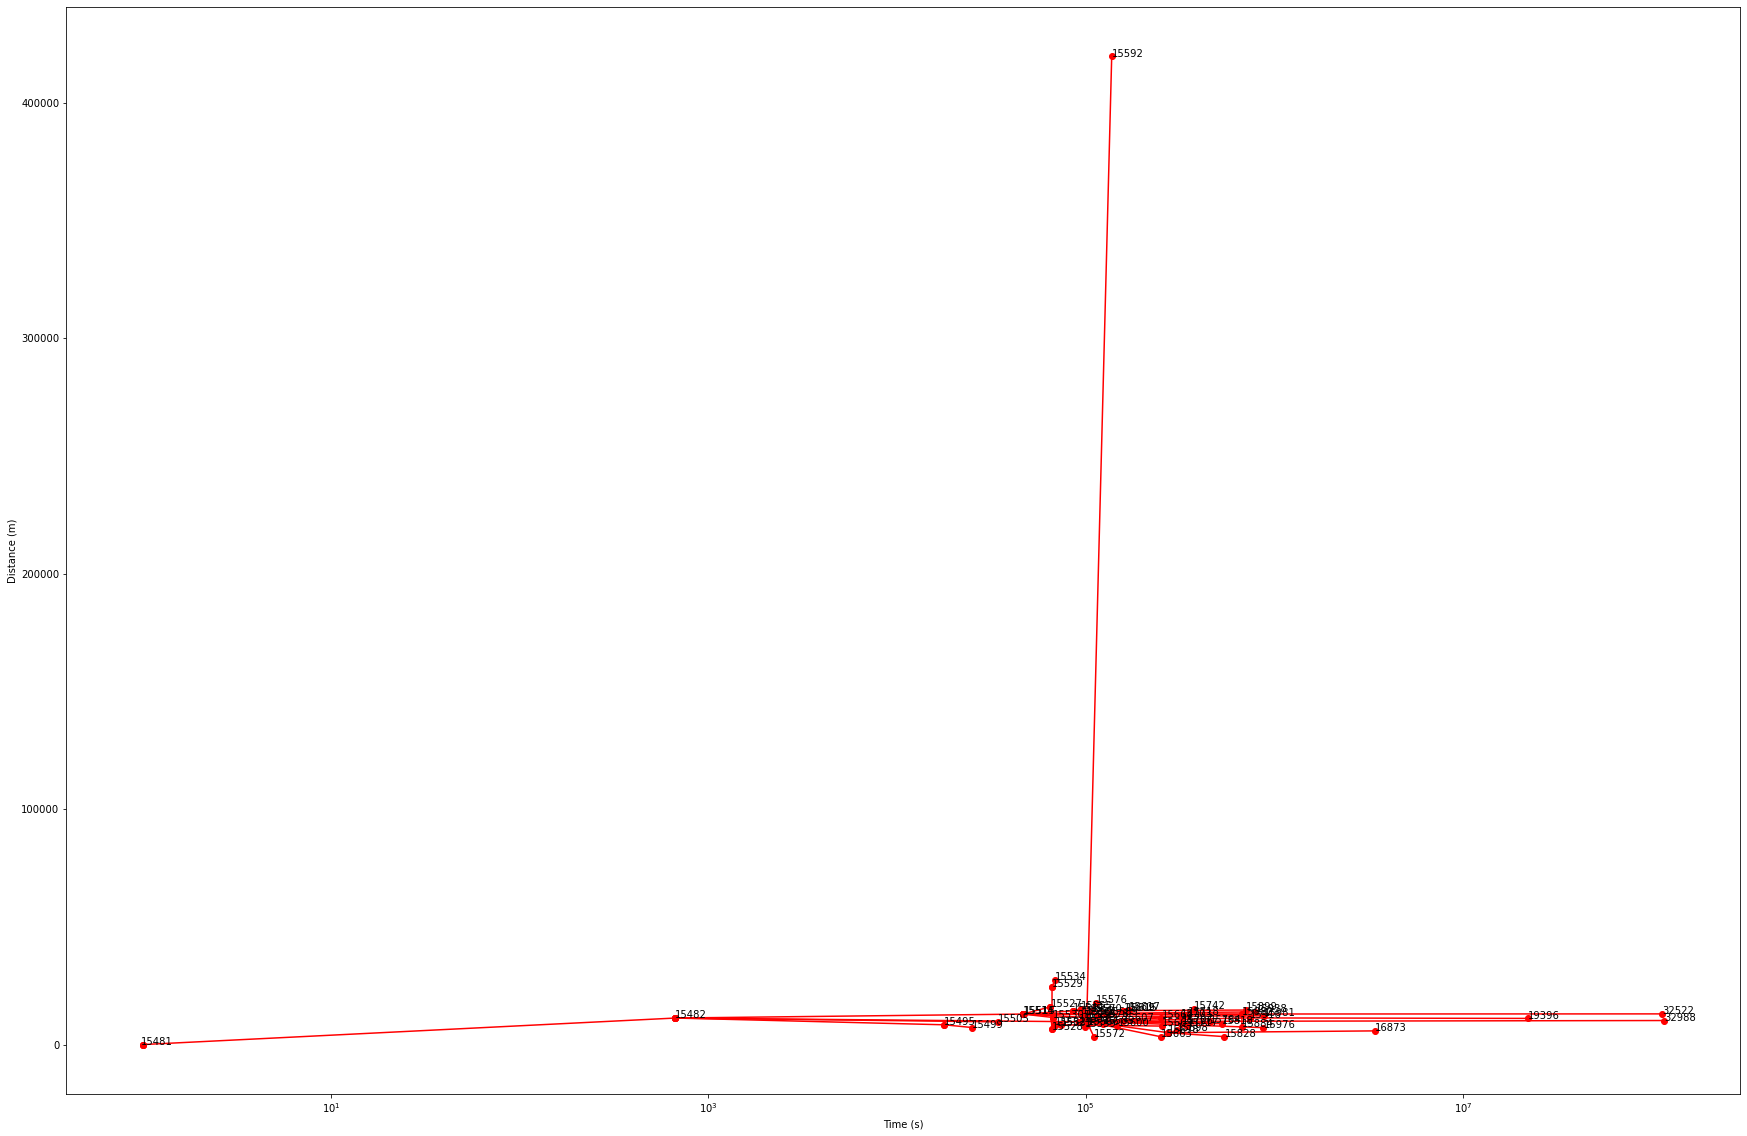

In [16]:
def plot_chains(ID,n_branches,data):
    ID_chains = aftershock_chains(ID,n_branches,data)
    fig = plt.figure(figsize=(30,20))
    plotted_IDs = set()
    for id_chain in list(ID_chains.keys()):
        prev_d = dist(ID,id_chain[0],data) + 1
        prev_t = time(ID,id_chain[0],data) + 1
        for id in id_chain:
            if id == id_chain[0]:
                d = dist(ID,id,data) + 1
                t = time(ID,id,data) + 1
            else:
                d = dist(ID,id,data)
                t = time(ID,id,data)
            if id not in plotted_IDs:
                plt.plot([prev_t,t],[prev_d,d],"ro-")
                plt.text(t-0.015, d+0.25, str(id))
            prev_d = d
            prev_t = t
            plotted_IDs.add(id)
    plt.xscale("log")
    plt.xlabel("Time (s)")
    plt.ylabel("Distance (m)")

plot_chains(15481,6,df)

EXPLAIN PLOT

<IPython.core.display.Javascript object>


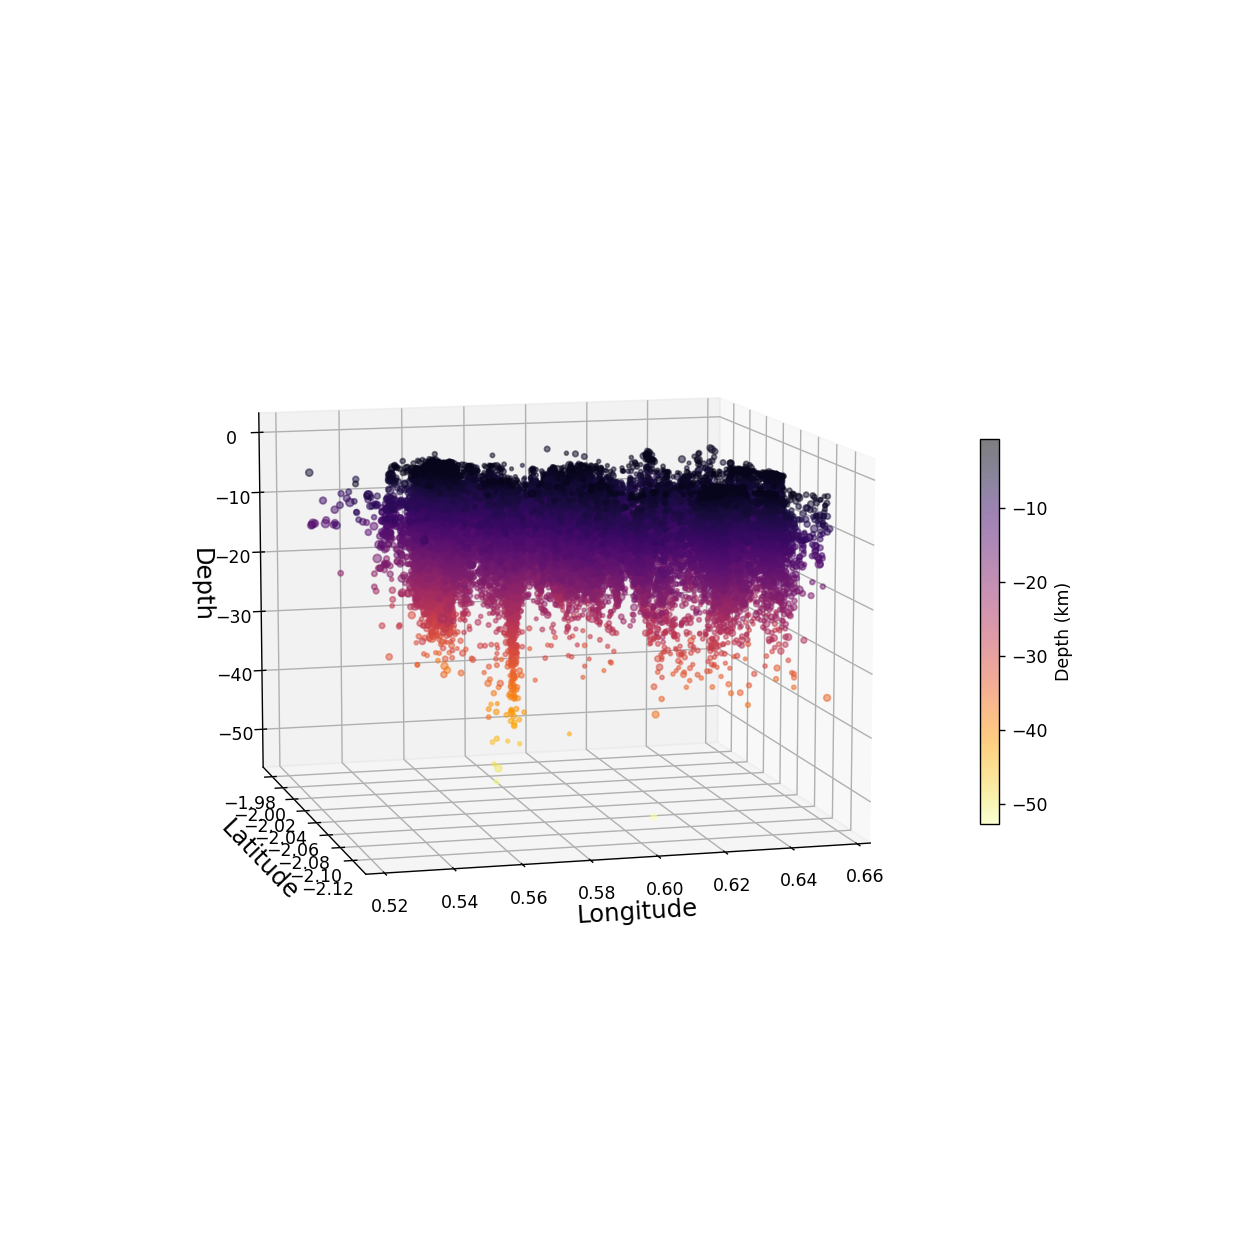

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")

m = 2

plot3d = ax.scatter3D(df["Longitude"][df["Magnitude"]>m],df["Latitude"][df["Magnitude"]>m],df["Depth"][df["Magnitude"]>m],s=df['Magnitude'][df['Magnitude']>m]**2,
                    c=df["Depth"][df['Magnitude']>m],alpha=0.5,cmap="inferno_r")
color = plt.colorbar(plot3d,ax=ax,shrink=0.4)
color.set_label(label="Depth (km)")
ax.set_xlabel("Longitude",fontsize=14)
ax.set_ylabel("Latitude",fontsize=14)
ax.set_zlabel("Depth",fontsize=14)
ax.view_init(azim = 255, elev = 10)
plt.show()

#change radians to degrees

In [ ]:
## SHOW BELLOW THE ANIMATION

EXPLAIN PLOT

# QUESTION 3

In [68]:
def waiting_times(df, m):
    df = copy.deepcopy(df[df["Magnitude"] > m])

    df["waiting_time"] = df["time"].diff(periods=1)
    
    return df.dropna()

In [69]:
df_wt2 = waiting_times(df, 2)
df_wt3 = waiting_times(df, 3)
df_wt4 = waiting_times(df, 4)
df_wt5 = waiting_times(df, 5)

wt2 = df_wt2["waiting_time"]
wt3 = df_wt3["waiting_time"]
wt4 = df_wt4["waiting_time"]
wt5 = df_wt5["waiting_time"]

# LINEAR BIN

In [70]:
def hist_plot(data,min_xlim,max_xlim,nb):
    #nb =int(10*np.round(2*(len(data)**(1/3))))
    #nb = int(10*np.sqrt(len(data)))
    binning = np.linspace(0,max(data)*(1+1/100),nb)
    
    %matplotlib inline

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (9,3))
    
    counts,bins_edges,patches = ax1.hist(data.values,bins=binning,density=True)
    ax1.set_title('Linearly spaced bins, linear axes')
    ax1.set_xlabel('Waiting time')
    ax1.set_ylabel('Frequencies')
    ax1.set_xlim(min_xlim,max_xlim)
    
    bins_center  = 1/2*(bins_edges[1:]+bins_edges[:-1])
    
    counts,bins_edges = np.histogram(data.values,bins=binning,density=True)

    plot_log = ax2.plot(bins_center, counts, '.')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_title('Linearly spaced bins, log axes')
    ax2.set_xlabel('log(Waiting time)')
    ax2.set_ylabel('log(Frequencies)')
    
    fig.tight_layout()

    return bins_center,counts

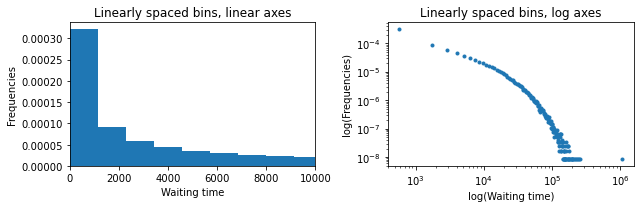

In [71]:
nb =int(10*np.round(2*(len(wt2)**(1/3))))
b2,c2 = hist_plot(wt2,0,1e4,nb)  #cut graph for visualize histo

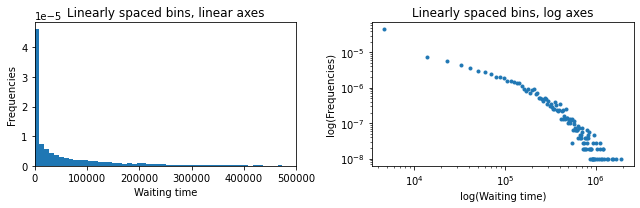

In [72]:
nb =int(10*np.round(2*(len(wt4)**(1/3))))
b3,c3 = hist_plot(wt3,0,0.5e6,nb)

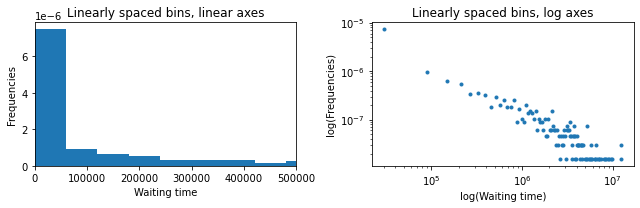

In [73]:
nb =int(10*np.round(2*(len(wt4)**(1/3))))
b4,c4 = hist_plot(wt4,0,0.5e6,nb)  #cut graph for visualize better histo
#b4,c4 = hist_plot(wt4,12.5e6,0,1.3e7,nb) #can visualize also the last bin

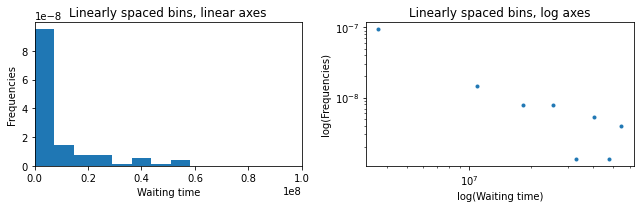

In [74]:
nb =int(np.round(2*(len(wt5)**(1/3))))  #no cut graph here, already weel visualized
b5,c5 = hist_plot(wt5,0,1e8,nb)   #too many bins for this, so put 3 instead of 10 in nb

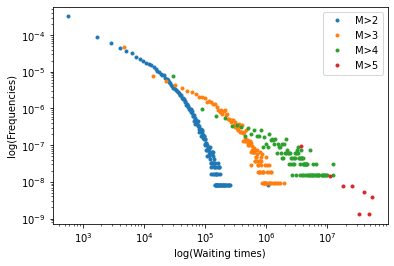

In [75]:
plt.plot(b2,c2,'.',label='M>2')
plt.plot(b3,c3,'.',label='M>3')
plt.plot(b4,c4,'.',label='M>4')
plt.plot(b5,c5,'.',label='M>5')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('log(Waiting times)')
plt.ylabel('log(Frequencies)')
plt.show()

In [76]:
### JUST SHOW THE M>2 AND LAST PLOT

Need more bins to actually visualize the shape of the histogram in linear scale.
By putting the log-log scale, i see the problem of linear binning (the problem is visible also with less bin, but here is better visualizable)

# LOG BIN

In [77]:
def hist_plot_logbin(data,min_logspace,max_logspace,xlim_min,xlim_max,nb):
    #nb =int(np.round(2*len(data)**(1/3)))
    #nb = int(np.sqrt(len(data)))
    binning = np.logspace(min_logspace,max_logspace,nb)
    
    %matplotlib inline

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (9,3))
    counts,bins_edges,patches = ax1.hist(data.values,bins=binning,density=True)
    ax1.set_title('Linearly spaced bins, linear axes')
    ax1.set_xlim(xlim_min,xlim_max)
    ax1.set_title('Log spaced bins, linear axes')
    ax1.set_xlabel('Waiting time')
    ax1.set_ylabel('Frequencies')
    
    bins_center  = 1/2*(bins_edges[1:]+bins_edges[:-1])
        
    
    counts,bins_edges = np.histogram(data.values,bins=binning,density=True)

    
    
    plot_log = ax2.plot(bins_center, counts, '.')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_title('Log spaced bins, log axes')
    ax2.set_xlabel('log(Waiting time)')
    ax2.set_ylabel('log(Frequencies)')
    
    fig.tight_layout()
    
    return bins_center,counts

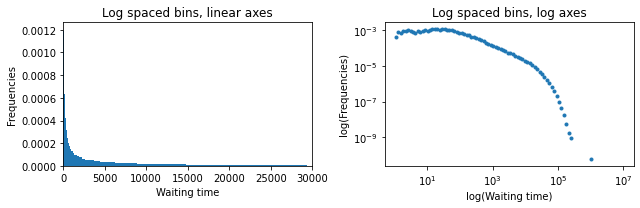

In [78]:
nb =int(np.round(2*len(wt2)**(1/3)))
binlog2,countlog2 = hist_plot_logbin(wt2,0,7,0,3e4,nb)  #cut graph to visualize better histo

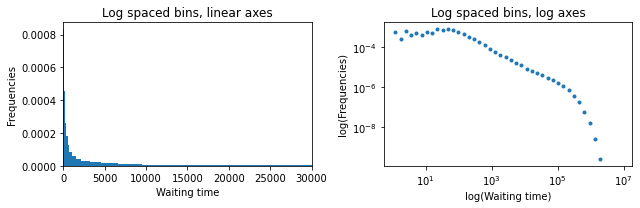

In [79]:
nb =int(np.round(2*len(wt3)**(1/3)))
binlog3,countlog3 = hist_plot_logbin(wt3,0,7,0,3e4,nb)   #cut graph to visualize better histo

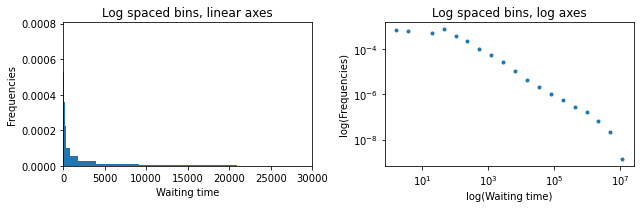

In [80]:
nb =int(np.round(2*len(wt4)**(1/3)))
binlog4,countlog4 = hist_plot_logbin(wt4,0,7.2,0,3e4,nb)   #cut graph to visualize better histo

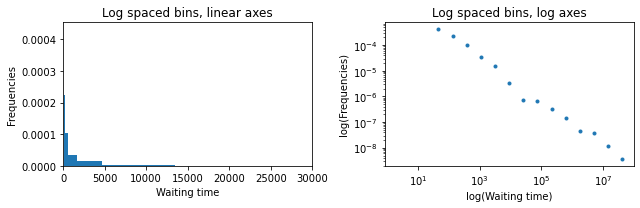

In [81]:
nb =int(2*np.round(2*len(wt5)**(1/3)))    
binlog5,countlog5 = hist_plot_logbin(wt5,0,7.8,0,3e4,nb)  #need more bins now to visualize well  #no cut graph, already ok

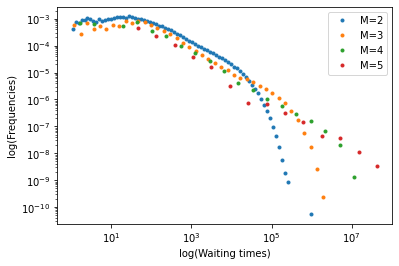

In [82]:
plt.plot(binlog2,countlog2,'.',label='M=2')
plt.plot(binlog3,countlog3,'.',label='M=3')
plt.plot(binlog4,countlog4,'.',label='M=4')
plt.plot(binlog5,countlog5,'.',label='M=5')

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('log(Waiting times)')
plt.ylabel('log(Frequencies)')
plt.show()

By using log binning, no more needed lots of bins.
In magnitude > 5 (last plot), need more bins to show the histogram.

# FIT

In [79]:
def fit(bins,count,min,max):
    bins = np.array(bins)
    count = np.array(count)
    x=np.log(bins[(bins>min) & (bins<max)])
    y=np.log(count[(bins>min) & (bins<max)])
    fit=stats.linregress(x,y)
    print(fit.slope,'+-',fit.stderr,np.e**fit.intercept,'+-',np.e**fit.intercept*fit.intercept_stderr)
    return(fit.slope,np.e**fit.intercept)

In [80]:
fit_wt2=fit(binlog2,countlog2,1e2,1e4)
fit_wt3=fit(binlog3,countlog3,1e2,1e4)
fit_wt4=fit(binlog4,countlog4,1e2,1e4)
fit_wt5=fit(binlog5,countlog5,1e2,1e4)

### maybe use diferent max???

-0.8034377497107961 +- 0.007132783049360858 0.03486704181845912 +- 0.0017596359555150409
-0.9160139502840081 +- 0.010312020714515339 0.04481424688548187 +- 0.003276674408909402
-0.8398817774145466 +- 0.03379257238667498 0.020003288497192663 +- 0.004638853203655406
-0.9788785869085003 +- 0.07443511129175653 0.03193822848852406 +- 0.017017510273488412


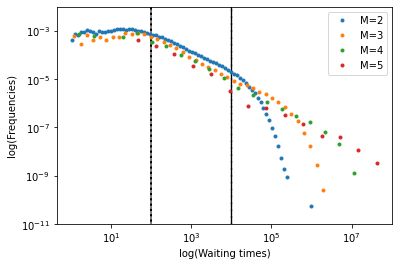

In [81]:
plt.plot(binlog2,countlog2,'.',label='M=2')
plt.plot(binlog3,countlog3,'.',label='M=3')
plt.plot(binlog4,countlog4,'.',label='M=4')
plt.plot(binlog5,countlog5,'.',label='M=5')

plt.arrow(1e2,0,0,1,ls='--')
plt.arrow(1e4,0,0,1,ls='--',lw=1.3)
plt.ylim(1e-11,1e-2)

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('log(Waiting times)')
plt.ylabel('log(Frequencies)')
plt.show()

/tmp/ipykernel_310/3588945984.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  for i in range(0,len(countlog2[[(binlog2>1e2) & (binlog2<1e4)]])):
/tmp/ipykernel_310/3588945984.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  erry.append(np.sqrt(countlog2[[(binlog2>1e2) & (binlog2<1e4)]][i]))
/tmp/ipykernel_310/3588945984.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]

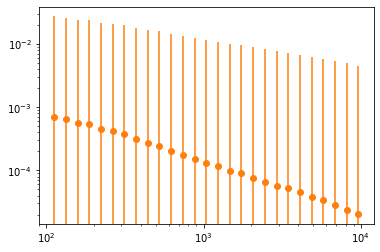

In [32]:
erry = []
for i in range(0,len(countlog2[[(binlog2>1e2) & (binlog2<1e4)]])):
    erry.append(np.sqrt(countlog2[[(binlog2>1e2) & (binlog2<1e4)]][i]))

plt.plot(binlog2[[(binlog2>1e2) & (binlog2<1e4)]], countlog2[[(binlog2>1e2) & (binlog2<1e4)]],'.')
plt.errorbar(binlog2[[(binlog2>1e2) & (binlog2<1e4)]], countlog2[[(binlog2>1e2) & (binlog2<1e4)]], erry, fmt='o')
plt.xscale('log')
plt.yscale('log')
###FINISH

make correct fit w/errors

In [105]:
def f(x,slope,intercept):
    return(intercept*x**slope)

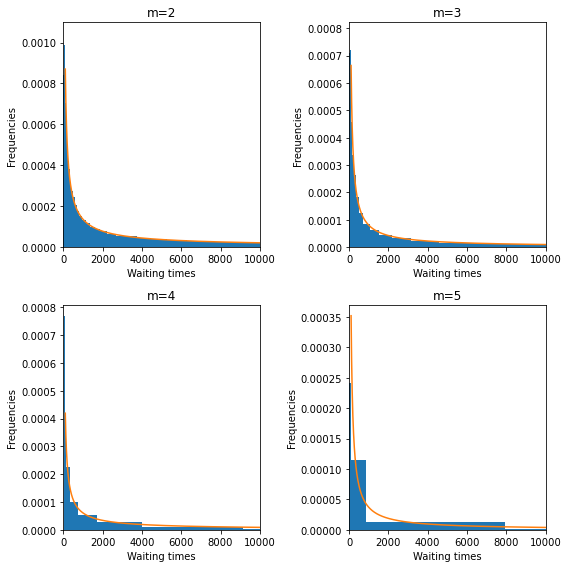

In [34]:
%matplotlib inline
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

x=np.linspace(100,10000,int(1e5))

nb =int(np.round(2*len(wt2)**(1/3)))
counts,bins_edges,patches = ax1.hist(wt2.values,bins=np.logspace(0,7,nb),density=True)
ax1.set_title('m=2')
ax1.set_xlabel('Waiting times')
ax1.set_ylabel('Frequencies')
ax1.plot(x,f(x,fit_wt2[0],fit_wt2[1]))


ax1.set_xlim(0,1e4)


nb =int(np.round(2*len(wt3)**(1/3)))
counts,bins_edges,patches = ax2.hist(wt3.values,bins=np.logspace(0,7,nb),density=True)
ax2.set_title('m=3')
ax2.set_xlabel('Waiting times')
ax2.set_ylabel('Frequencies')
ax2.plot(x,f(x,fit_wt3[0],fit_wt3[1]))


ax2.set_xlim(0,1e4)


nb =int(np.round(2*len(wt4)**(1/3)))
counts,bins_edges,patches = ax3.hist(wt4.values,bins=np.logspace(0,7.2,nb),density=True)
ax3.set_title('m=4')
ax3.set_xlabel('Waiting times')
ax3.set_ylabel('Frequencies')
ax3.plot(x,f(x,fit_wt4[0],fit_wt4[1]))


ax3.set_xlim(0,1e4)



nb =int(np.round(2*len(wt5)**(1/3)))
counts,bins_edges,patches = ax4.hist(wt5.values,bins=np.logspace(0,7.8,nb),density=True)
ax4.set_title('m=5')
ax4.set_xlabel('Waiting times')
ax4.set_ylabel('Frequencies')
ax4.plot(x,f(x,fit_wt5[0],fit_wt5[1]))


ax4.set_xlim(0,1e4)

fig.tight_layout()
fig.show()   
#LEGEND

Fit the linear region in log-log scale, so i get the actual function in linear scale.
Use correcet binning, but cut graph to focus on region of fitting

# QUESTION 4

In [5]:
def distances(df):
    df["distances"] = np.sqrt((df["X"].diff(periods=1))**2 + (df["Y"].diff(periods=1))**2 + (df["Z"].diff(periods=1))**2)
    return df.dropna()


In [6]:
df_dist2=distances(df_wt2)
df_dist3=distances(df_wt3)
df_dist4=distances(df_wt4)
df_dist5=distances(df_wt5)

dist2 = df_dist2['distances']
dist3 = df_dist3['distances']
dist4 = df_dist4['distances']
dist5 = df_dist5['distances']

# LINEAR BIN

In [84]:
def hist_plot_d(data,max_linspace,xmin,xmax,nb):
    #nb =int(np.round(2*len(data)**(1/3)))
    binning = np.linspace(0,max_linspace,nb)
    
    %matplotlib inline

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (9,3))
    
    counts,bins_edges,patches = ax1.hist(data.values,bins=binning,density=True)
    ax1.set_title('Linearly spaced bins, linear axes')
    ax1.set_xlabel('Distances')
    ax1.set_ylabel('Frequencies')
    ax1.set_xlim(xmin,xmax)
    
    bins_center  = 1/2*(bins_edges[1:]+bins_edges[:-1])
    
    counts,bins_edges = np.histogram(data.values,bins=binning,density=True)

    plot_log = ax2.plot(bins_center, counts, '.')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_title('Linearly spaced bins, log axes')
    ax2.set_xlabel('log(Distances)')
    ax2.set_ylabel('log(Frequencies)')
    
    fig.tight_layout()

    return bins_center,counts

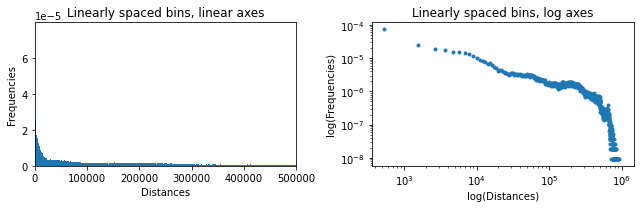

In [93]:
nb =int(10*np.round(2*len(dist2)**(1/3)))
bd2,cd2 = hist_plot_d(dist2,1e6,0,5e5,nb)
## biger?


Neee to choose between different nb:

# LOG BIN

In [94]:
def hist_plot_logbin_d(data,min_logspace,max_logspace,xlim_min,xlim_max,nb):
    #nb =int(np.round(2*len(data)**(1/3)))
    binning = np.logspace(min_logspace,max_logspace,nb)
    
    %matplotlib inline

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (9,3))
    counts,bins_edges,patches = ax1.hist(data.values,bins=binning,density=True)
    ax1.set_title('Linearly spaced bins, linear axes')
    ax1.set_xlim(xlim_min,xlim_max)
    ax1.set_title('Log spaced bins, linear axes')
    ax1.set_xlabel('Distances')
    ax1.set_ylabel('Frequencies')
    
    bins_center  = 1/2*(bins_edges[1:]+bins_edges[:-1])
        
    
    counts,bins_edges = np.histogram(data.values,bins=binning,density=True)

    
    
    plot_log = ax2.plot(bins_center, counts, '.')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_title('Log spaced bins, log axes')
    ax2.set_xlabel('log(Distances)')
    ax2.set_ylabel('log(Frequencies)')
    
    fig.tight_layout()
    
    return bins_center,counts

In [43]:
max(dist2)

905481.9989298517

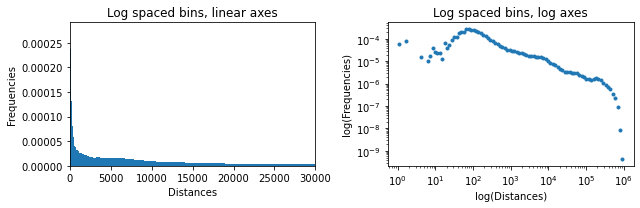

In [95]:
nb =int(np.round(2*len(dist2)**(1/3)))
bdl2,cdl2 = hist_plot_logbin_d(dist2,0,6,0,3e4,nb)  #correct lenght binning, cut for visualize

1017909.5378789806

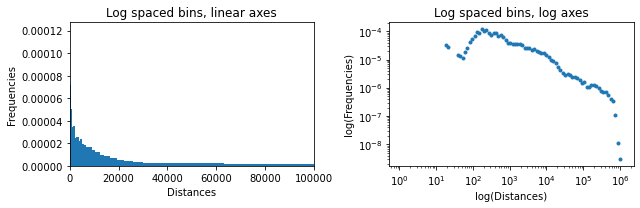

In [97]:
nb =int(np.round(2*len(dist2)**(1/3)))
bdl3,cdl3 = hist_plot_logbin_d(dist3,0,6.1,0,1e5,nb)  #correct binning, cut for visualize

In [98]:
max(dist4)

1005279.914810298

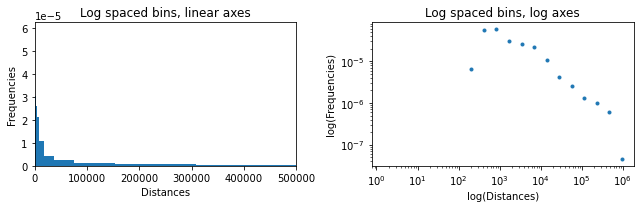

In [99]:
nb =int(np.round(2*len(dist4)**(1/3)))
bdl4,cdl4 = hist_plot_logbin_d(dist4,0,6.1,0,5e5,nb)  #correct binning, cut for visualize

In [100]:
max(dist5)

684507.2939998521

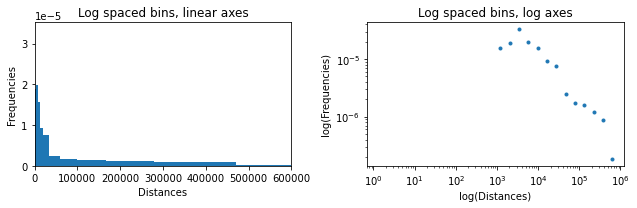

In [101]:
nb =int(3*np.round(2*len(dist5)**(1/3)))
bdl5,cdl5 = hist_plot_logbin_d(dist5,0,5.9,0,6e5,nb)  #need more bins, cut for visualize

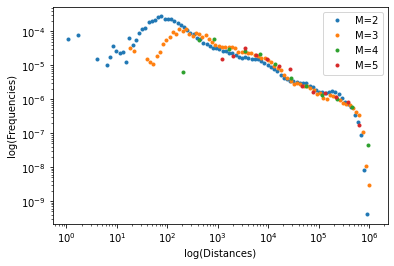

In [102]:
plt.plot(bdl2,cdl2,'.',label='M=2')
plt.plot(bdl3,cdl3,'.',label='M=3')
plt.plot(bdl4,cdl4,'.',label='M=4')
plt.plot(bdl5,cdl5,'.',label='M=5')

plt.xscale('log')
plt.yscale('log')

plt.legend(loc='best')
plt.xlabel('log(Distances)')
plt.ylabel('log(Frequencies)')
plt.show()
#### PLT ARROW FOR THE FIT REGIME

# FIT DISTANCES

In [112]:
min=1.8e3
max=1e5
fit_dist2=fit(bdl2,cdl2,1e2,max)
fit_dist3=fit(bdl3,cdl3,1.5e2,max)
fit_dist4=fit(bdl4,cdl4,1.2e3,max)
fit_dist5=fit(bdl5,cdl5,1.8e3,max)

#differnt mins for each data

-0.6767274645171101 +- 0.014054638729610321 0.004236755217296662 +- 0.0004916747607783623
-0.6829911647474067 +- 0.02038402410703241 0.0051154042504218235 +- 0.0008863666248719956
-0.7553295409648072 +- 0.10402642294001718 0.011557243755605075 +- 0.011142663918524125
-0.7587707506372728 +- 0.12583120023700486 0.01204897371321038 +- 0.014425350832353858


/tmp/ipykernel_658/1402047437.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  for i in range(0,len(countlog2[[(binlog2>1e2) & (binlog2<1e4)]])):
/tmp/ipykernel_658/1402047437.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  erry.append(np.sqrt(countlog2[[(binlog2>1e2) & (binlog2<1e4)]][i]))
/tmp/ipykernel_658/1402047437.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]

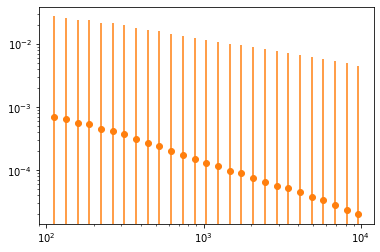

In [115]:
erry = []
for i in range(0,len(countlog2[[(binlog2>1e2) & (binlog2<1e4)]])):
    erry.append(np.sqrt(countlog2[[(binlog2>1e2) & (binlog2<1e4)]][i]))

plt.plot(binlog2[[(binlog2>1e2) & (binlog2<1e4)]], countlog2[[(binlog2>1e2) & (binlog2<1e4)]],'.')
plt.errorbar(binlog2[[(binlog2>1e2) & (binlog2<1e4)]], countlog2[[(binlog2>1e2) & (binlog2<1e4)]], erry, fmt='o')
plt.xscale('log')
plt.yscale('log')
###SAME BUT FOR DISTANCEEES!

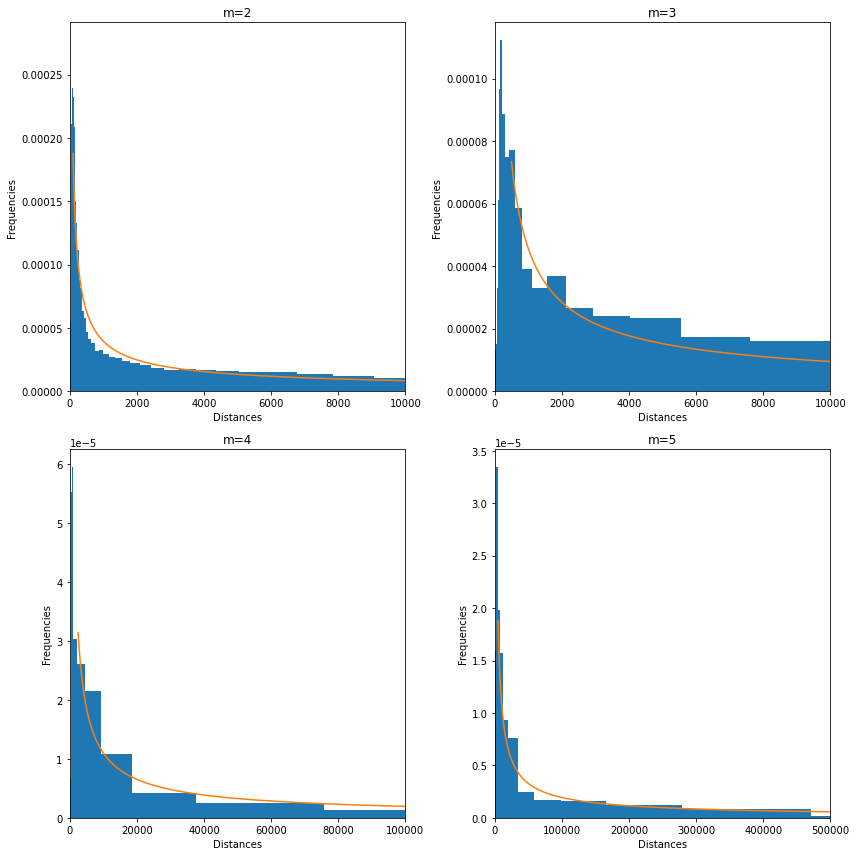

In [116]:
%matplotlib inline
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))

x=np.linspace(100,10000,int(1e5))

nb =int(np.round(2*len(dist2)**(1/3)))
counts,bins_edges,patches = ax1.hist(dist2.values,bins=np.logspace(0,6,nb),density=True)
ax1.set_title('m=2')
ax1.set_xlabel('Distances')
ax1.set_ylabel('Frequencies')
ax1.plot(x,f(x,fit_dist2[0],fit_dist2[1]))
ax1.set_xlim(0,1e4)


nb =int(np.round(2*len(dist3)**(1/3)))
counts,bins_edges,patches = ax2.hist(dist3.values,bins=np.logspace(0,6.1,nb),density=True)
ax2.set_title('m=3')
ax2.set_xlabel('Distances')
ax2.set_ylabel('Frequencies')
x=np.linspace(500,10000,int(1e5))
ax2.plot(x,f(x,fit_dist3[0],fit_dist3[1]))


ax2.set_xlim(0,1e4)


nb =int(np.round(2*len(dist4)**(1/3)))
counts,bins_edges,patches = ax3.hist(dist4.values,bins=np.logspace(0,6.1,nb),density=True)
ax3.set_title('m=4')
ax3.set_xlabel('Distances')
ax3.set_ylabel('Frequencies')
x=np.linspace(2500,1000000,int(1e5))
ax3.plot(x,f(x,fit_dist4[0],fit_dist4[1]))


ax3.set_xlim(0,1e5)



nb =int(3*np.round(2*len(dist5)**(1/3)))
counts,bins_edges,patches = ax4.hist(dist5.values,bins=np.logspace(0,5.9,nb),density=True)
ax4.set_title('m=5')
ax4.set_xlabel('Distances')
ax4.set_ylabel('Frequencies')
x=np.linspace(5000,1000000,int(1e4))
ax4.plot(x,f(x,fit_dist5[0],fit_dist5[1]))
ax4.set_xlim(0,5e5)
fig.tight_layout()
fig.show()

In [117]:
### MIX PLOTS WIHT LOG SCALE AND LIN SCALE

# QUESTION 5

5. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. (In this statistics, if the following event is farther than $R$, skip the $t$ and go to the next pair)

m=2

In [7]:
np.mean(wt2)

8762.64617609311

In [8]:
def mr(datam,c):
    R = np.mean(datam['distances'].values)
    mr= datam[datam['distances'] < np.mean(dist2)/c]['waiting_time']
    print('Percent of data: ',len(mr)/len(datam)*100, '%')
    return(mr)

In [9]:
mr2_1=mr(df_dist2,1)
mr2_2=mr(df_dist2,10)
mr2_3=mr(df_dist2,100)

Percent of data:  59.696222079927686 %
Percent of data:  26.650721307770535 %
Percent of data:  9.339334814870616 %


In [10]:
mr3_1=mr(df_dist3,1)
mr3_2=mr(df_dist3,10)
mr3_3=mr(df_dist3,100)

Percent of data:  61.522346368715084 %
Percent of data:  32.07925977653631 %
Percent of data:  8.266410614525139 %


In [11]:
mr4_1=mr(df_dist4,1)
mr4_2=mr(df_dist4,10)
mr4_3=mr(df_dist4,100)

Percent of data:  62.841530054644814 %
Percent of data:  32.14936247723133 %
Percent of data:  7.012750455373407 %


In [12]:
mr5_1=mr(df_dist5,1)
mr5_2=mr(df_dist5,10)
mr5_3=mr(df_dist5,100)

Percent of data:  61.165048543689316 %
Percent of data:  25.24271844660194 %
Percent of data:  0.9708737864077669 %


# LOG BINS


In [152]:
def hist_plot_5(data_1,data_2,data_3,min_logspace,max_logspace,xlim_min,xlim_max,nb1,nb2,nb3):
    
    
    %matplotlib inline

    fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows = 3, ncols = 2, figsize = (9,8))
    
    #nb=int(np.round(2*(len(data_1)**(1/3))))
    binning = np.logspace(min_logspace,max_logspace,nb1)
    
    counts_1,bins_edges_1,patches_1 = ax1.hist(data_1.values,bins=binning,density=True)
    ax1.set_title('R=mean(waiting times)')
    ax1.set_xlim(xlim_min,xlim_max)
    ax1.set_xlabel('Waiting times')
    ax1.set_ylabel('Frequencies')
    
    bins_center_1 = 1/2*(bins_edges_1[1:]+bins_edges_1[:-1])
        

    plot_log_1 = ax2.plot(bins_center_1, counts_1, '.')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_title('R=mean(waiting times)')
    ax2.set_xlabel('Waiting times')
    ax2.set_ylabel('Frequencies')

    #nb=int(np.round(2*(len(data_2)**(1/3))))
    binning = np.logspace(min_logspace,max_logspace,nb2)    

    counts_2,bins_edges_2,patches_2 = ax3.hist(data_2.values,bins=binning,density=True)
    ax3.set_title('R=mean(waiting times)/10')
    ax3.set_xlim(xlim_min,xlim_max)
    ax3.set_xlabel('Waiting times')
    ax3.set_ylabel('Frequencies')
    
    bins_center_2 = 1/2*(bins_edges_2[1:]+bins_edges_2[:-1])
        

    plot_log_2 = ax4.plot(bins_center_2, counts_2, '.')
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.set_title('R=mean(waiting times)/10')
    ax4.set_xlabel('Waiting times')
    ax4.set_ylabel('Frequencies')
    
    
    #nb=int(np.round(2*(len(data_3)**(1/3))))
    binning = np.logspace(min_logspace,max_logspace,nb3)

    counts_3,bins_edges_3,patches_3 = ax5.hist(data_3.values,bins=binning,density=True)
    ax5.set_title('R=mean(waiting times)/100')
    ax5.set_xlim(xlim_min,xlim_max)
    ax5.set_xlabel('Waiting times')
    ax5.set_ylabel('Frequencies')
    
    bins_center_3 =  1/2*(bins_edges_3[1:]+bins_edges_3[:-1])
        
    
    plot_log_3 = ax6.plot(bins_center_3, counts_3, '.')
    ax6.set_xscale('log')
    ax6.set_yscale('log')
    ax6.set_title('R=mean(waiting times)/100')
    ax6.set_xlabel('Waiting times')
    ax6.set_ylabel('Frequencies')
    
    
    
    
    fig.tight_layout()
    
    return bins_center_1,counts_1

In [153]:
np.max(mr2_1)

258054.16319999844

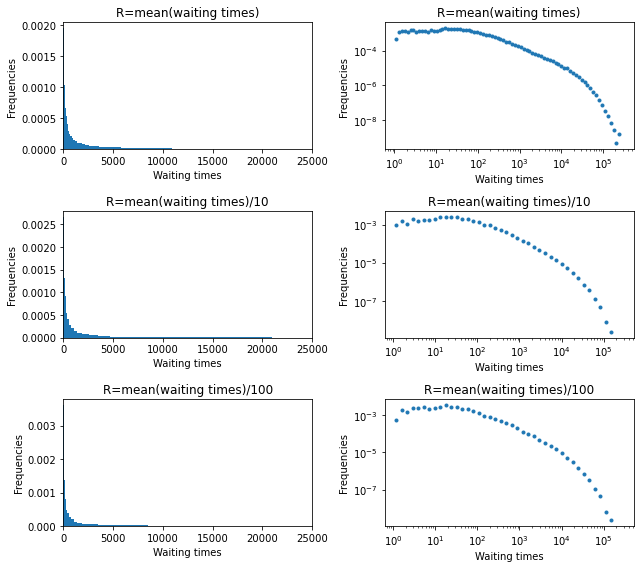

In [154]:
nb1=int(np.round(2*(len(mr2_1)**(1/3))))
nb2=int(np.round(2*(len(mr2_3)**(1/3))))
nb3=int(np.round(2*(len(mr2_3)**(1/3))))
b1,c1 = hist_plot_5(mr2_1,mr2_2,mr2_3,0,5.5,0,2.5e4,nb1,nb2,nb3)
#binning lenght correct for the first for now, for the other should be smaller

In [155]:
np.max(mr3_1)

1699187.6044800282

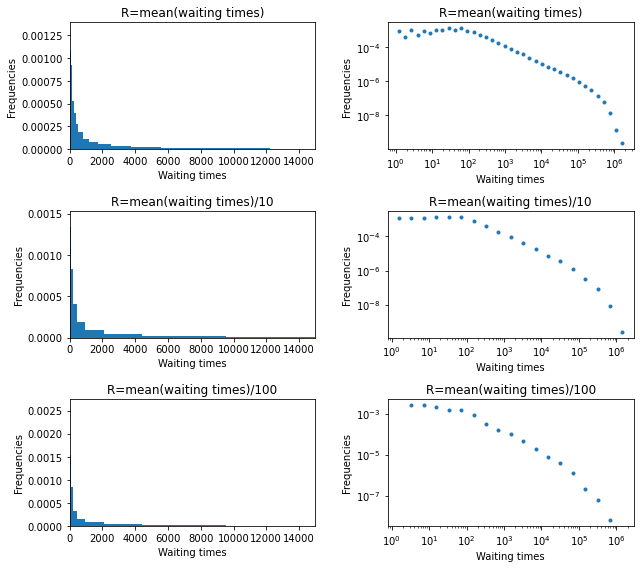

In [156]:
nb1=int(np.round(2*(len(mr3_1)**(1/3))))
nb2=int(np.round(2*(len(mr3_3)**(1/3))))
nb3=int(np.round(2*(len(mr3_3)**(1/3))))
b2,c2=hist_plot_5(mr3_1,mr3_2,mr3_3,0,6.3,0,1.5e4,nb1,nb2,nb3)
#binning lenght correct for the first for now, for the other should be smaller

In [157]:
np.max(mr4_1)

12353529.73248002

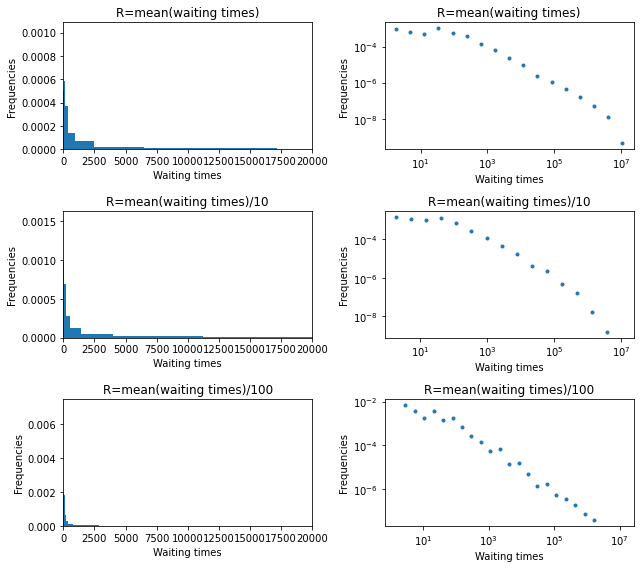

In [158]:
nb1=int(np.round(2*(len(mr4_1)**(1/3))))
nb2=int(np.round(4*(len(mr4_3)**(1/3))))
nb3=int(np.round(6*(len(mr4_3)**(1/3))))
b3,c3=hist_plot_5(mr4_1,mr4_2,mr4_3,0,7.2,0,2e4,nb1,nb2,nb3)
#binning lenght correct for the first for now, for the other should be smaller

In [159]:
np.max(mr5_1)

54096700.789440036

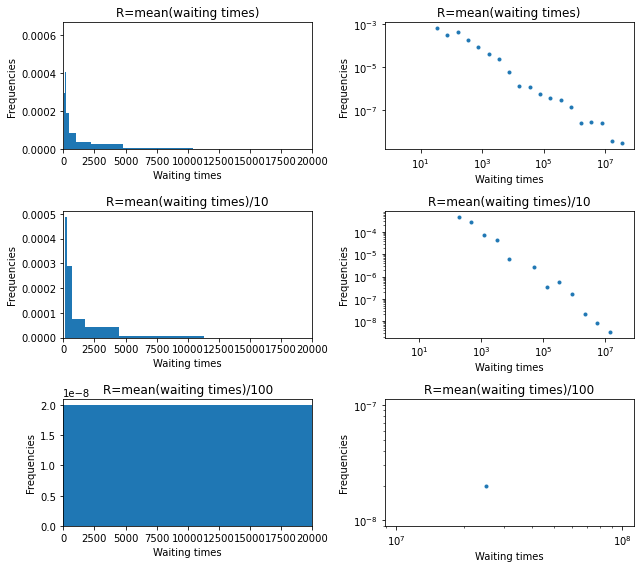

In [160]:
nb1=int(3*np.round(2*(len(mr5_1)**(1/3))))
nb2=int(10*np.round(2*(len(mr5_3)**(1/3))))
nb3=int(np.round(2*(len(mr5_3)**(1/3))))  #useless, just 1 point in mr5_3
b4,c4=hist_plot_5(mr5_1,mr5_2,mr5_3,0,7.7,0,2e4,nb1,nb2,nb3)
#binning lenght correct for the first for now, for the other should be smaller

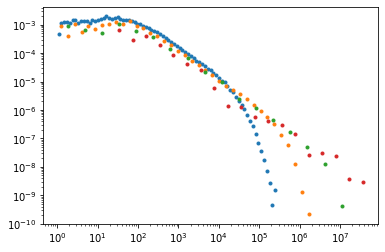

In [161]:
plt.plot(b1,c1,'.')
plt.plot(b2,c2,'.')
plt.plot(b3,c3,'.')
plt.plot(b4,c4,'.')

plt.xscale('log')
plt.yscale('log')

Can fit the ''linear region''

In principle each histogram should have its own number of bins and lenght of binning logspace.

In [ ]:
#### CHOSE R, but R the same for all the M.

# EXERCISE 6 

6. Eventually note if, from the analysis of the previous points, there emerges a scaling picture. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 5 is considered) on a single curve?

In [17]:
wt2 = df_wt2["waiting_time"]
wt3 = df_wt3["waiting_time"]
wt4 = df_wt4["waiting_time"]
wt5 = df_wt5["waiting_time"]

In [18]:
wt2_r = wt2/np.mean(wt2)
wt3_r = wt3/np.mean(wt3)
wt4_r = wt4/np.mean(wt4)
wt5_r = wt5/np.mean(wt5)

In [33]:
print(max(wt2_r))
np.logspace(0,2.1,nb)

122.50382666924163


array([  1.        ,   1.01503608,   1.03029825,   1.0457899 ,
         1.06151449,   1.07747551,   1.09367652,   1.11012113,
         1.12681301,   1.14375586,   1.16095347,   1.17840967,
         1.19612833,   1.21411342,   1.23236893,   1.25089893,
         1.26970755,   1.28879898,   1.30817747,   1.32784734,
         1.34781296,   1.36807879,   1.38864934,   1.40952919,
         1.43072299,   1.45223546,   1.47407139,   1.49623566,
         1.51873318,   1.54156898,   1.56474814,   1.58827583,
         1.61215728,   1.63639781,   1.66100282,   1.6859778 ,
         1.7113283 ,   1.73705998,   1.76317856,   1.78968986,
         1.81659979,   1.84391434,   1.87163959,   1.89978172,
         1.92834699,   1.95734178,   1.98677254,   2.01664582,
         2.04696827,   2.07774666,   2.10898783,   2.14069875,
         2.17288648,   2.20555818,   2.23872114,   2.27238274,
         2.30655048,   2.34123196,   2.37643492,   2.4121672 ,
         2.44843675,   2.48525165,   2.5226201 ,   2.56

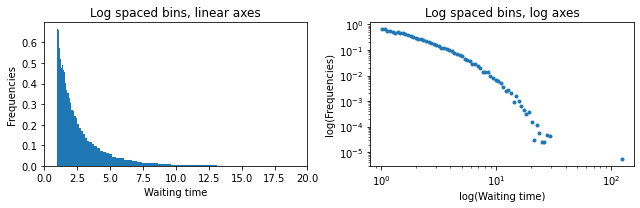

In [34]:
nb =int(np.round(2*len(wt2_r)**(1/3)))
#nb = int(np.sqrt(len(wt2_r)))
bdl2,cdl2 = hist_plot_logbin(wt2_r,0,2.1,0,2e1,nb)

In [37]:
print(max(wt3_r))
np.logspace(0,1.4,nb)

23.68177351112919


array([ 1.        ,  1.03488863,  1.07099448,  1.10836002,  1.14702918,
        1.18704747,  1.22846193,  1.27132129,  1.31567595,  1.36157809,
        1.40908169,  1.45824262,  1.50911871,  1.5617698 ,  1.61625782,
        1.67264684,  1.73100321,  1.79139554,  1.85389489,  1.91857475,
        1.9855112 ,  2.05478297,  2.12647154,  2.20066123,  2.27743929,
        2.35689603,  2.43912492,  2.52422265,  2.61228933,  2.70342854,
        2.79774746,  2.89535705,  2.9963721 ,  3.10091143,  3.20909799,
        3.32105904,  3.43692625,  3.55683591,  3.68092905,  3.80935164,
        3.94225471,  4.07979459,  4.22213305,  4.3694375 ,  4.52188121,
        4.67964346,  4.84290983,  5.01187234,  5.18672971,  5.36768763,
        5.55495891,  5.74876384,  5.94933035,  6.15689436,  6.37169999,
        6.5939999 ,  6.82405555,  7.06213752,  7.30852585,  7.56351033,
        7.82739087,  8.10047784,  8.38309244,  8.67556708,  8.97824577,
        9.29148449,  9.61565169,  9.95112864, 10.29830992, 10.65

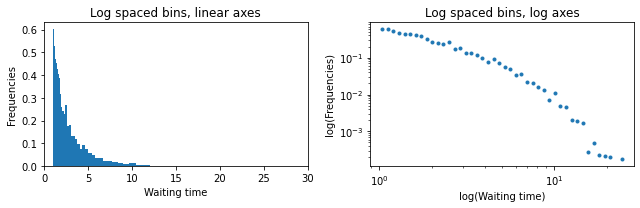

In [39]:
nb =int(np.round(2*len(wt3_r)**(1/3)))
bdl3,cdl3 = hist_plot_logbin(wt3_r,0,1.4,0,30,nb)

In [43]:
print(max(wt4_r))
np.logspace(0,1.2)

14.795027622734038


array([ 1.        ,  1.05801006,  1.11938528,  1.18432088,  1.25302341,
        1.32571137,  1.40261596,  1.48398179,  1.57006766,  1.66114737,
        1.75751062,  1.85946392,  1.96733152,  2.08145654,  2.20220195,
        2.32995181,  2.46511245,  2.60811376,  2.75941059,  2.91948415,
        3.0888436 ,  3.26802759,  3.45760606,  3.65818198,  3.87039333,
        4.09491506,  4.33246132,  4.58378765,  4.84969343,  5.13102442,
        5.42867544,  5.74359321,  6.07677938,  6.4292937 ,  6.80225739,
        7.19685673,  7.6143468 ,  8.05605549,  8.52338773,  9.01782994,
        9.54095476, 10.09442609, 10.68000433, 11.29955198, 11.95503964,
       12.64855217, 13.3822954 , 14.15860312, 14.97994449, 15.84893192])

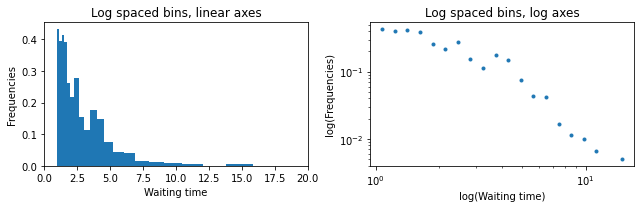

In [53]:
nb =int(np.round(2*len(wt4_r)**(1/3)))
bdl4,cdl4 = hist_plot_logbin(wt4_r,0,1.2,0,20,nb)

In [54]:
print(max(wt5_r))
np.logspace(0,0.9)

6.701704232402178


array([1.        , 1.04319944, 1.08826508, 1.13527753, 1.18432088,
       1.23548289, 1.28885506, 1.34453288, 1.40261596, 1.46320819,
       1.52641797, 1.59235837, 1.66114737, 1.73290801, 1.80776868,
       1.88586328, 1.96733152, 2.05231915, 2.1409782 , 2.23346727,
       2.32995181, 2.43060443, 2.53560519, 2.64514193, 2.75941059,
       2.87861559, 3.00297019, 3.13269683, 3.26802759, 3.40920456,
       3.55648031, 3.71011828, 3.87039333, 4.03759217, 4.2120139 ,
       4.39397056, 4.58378765, 4.78180472, 4.98837603, 5.2038711 ,
       5.42867544, 5.6631912 , 5.90783791, 6.16305322, 6.4292937 ,
       6.70703561, 6.99677582, 7.29903265, 7.6143468 , 7.94328235])

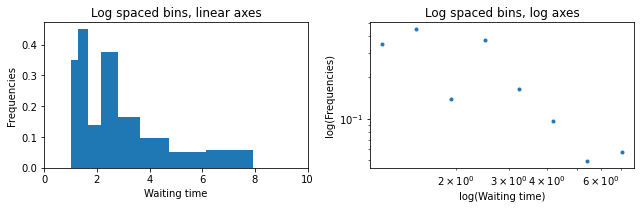

In [55]:
nb =int(np.round(2*len(wt5_r)**(1/3)))
bdl5,cdl5 = hist_plot_logbin(wt5_r,0,0.9,0,10,nb)

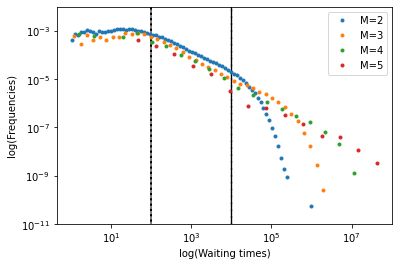

In [83]:
plt.plot(binlog2,countlog2,'.',label='M=2')
plt.plot(binlog3,countlog3,'.',label='M=3')
plt.plot(binlog4,countlog4,'.',label='M=4')
plt.plot(binlog5,countlog5,'.',label='M=5')

plt.arrow(1e2,0,0,1,ls='--')
plt.arrow(1e4,0,0,1,ls='--',lw=1.3)
plt.ylim(1e-11,1e-2)

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('log(Waiting times)')
plt.ylabel('log(Frequencies)')
plt.show()

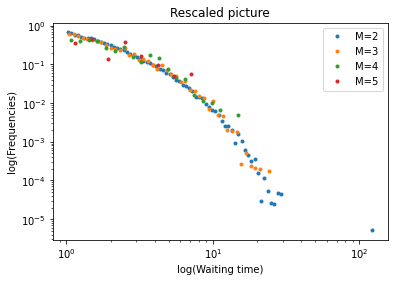

In [58]:
plt.plot(bdl2,cdl2,'.',label='M=2')
plt.plot(bdl3,cdl3,'.',label='M=3')
plt.plot(bdl4,cdl4,'.',label='M=4')
plt.plot(bdl5,cdl5,'.',label='M=5')

plt.xscale('log')
plt.yscale('log')

plt.legend(loc='best')
plt.xlabel('log(Waiting time)')
plt.ylabel('log(Frequencies)')
plt.title('Rescaled picture')
plt.show()
#### PLT ARROW FOR THE FIT REGIME

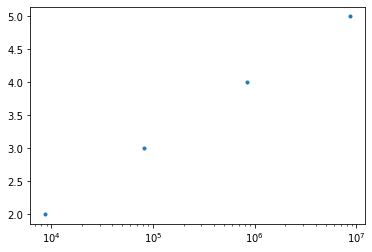

In [66]:
averages = np.array([np.mean(wt2),np.mean(wt3),np.mean(wt4),np.mean(wt5)])
mag = np.array([2,3,4,5])
plt.plot(averages,mag,'.')
plt.xscale('log')

In [168]:
def mr(datam,c):
    R = np.mean(datam['distances'].values)
    mr= datam[datam['distances'] < np.mean(dist2)/c]['waiting_time']
    print('Percent of data: ',len(mr)/len(datam)*100, '%')
    return(mr)

In [169]:
wt2_ddd = mr(df_dist2,3)
wt2_r_d = wt2_ddd/np.mean(wt2_ddd)

Percent of data:  39.74160985347847 %


In [170]:
wt3_ddd = mr(df_dist3,3)
wt3_r_d = wt3_ddd/np.mean(wt3_ddd)

Percent of data:  45.5481843575419 %


In [171]:
wt4_ddd = mr(df_dist4,3)
wt4_r_d = wt4_ddd/np.mean(wt4_ddd)

Percent of data:  46.26593806921676 %


In [172]:
wt5_ddd = mr(df_dist5,3)
wt5_r_d = wt5_ddd/np.mean(wt5_ddd)

Percent of data:  45.63106796116505 %


In [173]:
print(max(wt2_r_d))
np.logspace(0,1.7)

47.37940000989481


array([ 1.        ,  1.08316315,  1.17324241,  1.27081295,  1.37649776,
        1.49097166,  1.61496556,  1.74927119,  1.89474609,  2.05231915,
        2.22299648,  2.40786788,  2.60811376,  2.82501272,  3.05994969,
        3.31442475,  3.59006276,  3.8886237 ,  4.2120139 ,  4.56229826,
        4.94171336,  5.35268182,  5.79782772,  6.27999335,  6.80225739,
        7.36795456,  7.98069689,  8.6443968 ,  9.36329209, 10.14197298,
       10.98541142, 11.89899286, 12.88855062, 13.96040312, 15.12139425,
       16.37893707, 17.74106111, 19.21646368, 20.81456538, 22.54557025,
       24.42053095, 26.45141928, 28.6512027 , 31.03392703, 33.61480624,
       36.41031949, 39.43831644, 42.71813116, 46.27070562, 50.11872336])

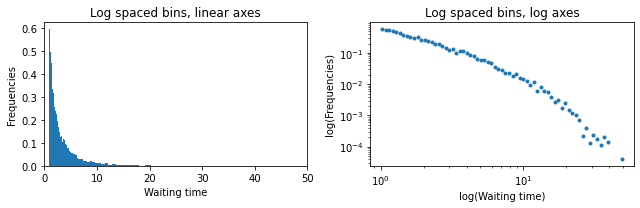

In [174]:
nb =int(np.round(2*len(wt2_r_d)**(1/3)))
bdist2,cdist2 = hist_plot_logbin(wt2_r_d,0,1.7,0,50,nb)

In [175]:
print(max(wt3_r_d))
np.logspace(0,1.7)

42.80968090431673


array([ 1.        ,  1.08316315,  1.17324241,  1.27081295,  1.37649776,
        1.49097166,  1.61496556,  1.74927119,  1.89474609,  2.05231915,
        2.22299648,  2.40786788,  2.60811376,  2.82501272,  3.05994969,
        3.31442475,  3.59006276,  3.8886237 ,  4.2120139 ,  4.56229826,
        4.94171336,  5.35268182,  5.79782772,  6.27999335,  6.80225739,
        7.36795456,  7.98069689,  8.6443968 ,  9.36329209, 10.14197298,
       10.98541142, 11.89899286, 12.88855062, 13.96040312, 15.12139425,
       16.37893707, 17.74106111, 19.21646368, 20.81456538, 22.54557025,
       24.42053095, 26.45141928, 28.6512027 , 31.03392703, 33.61480624,
       36.41031949, 39.43831644, 42.71813116, 46.27070562, 50.11872336])

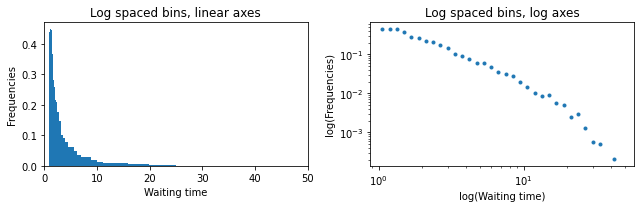

In [176]:
nb =int(np.round(2*len(wt3_r_d)**(1/3)))
bdist3,cdist3 = hist_plot_logbin(wt3_r_d,0,1.7,0,50,nb)

In [177]:
print(max(wt4_r_d))
np.logspace(0,1.6)

36.01211184721325


array([ 1.        ,  1.07808514,  1.16226758,  1.25302341,  1.35086592,
        1.45634848,  1.57006766,  1.69266662,  1.82483873,  1.96733152,
        2.12095089,  2.28656564,  2.46511245,  2.65760111,  2.86512027,
        3.0888436 ,  3.33003639,  3.59006276,  3.87039333,  4.17261354,
        4.49843267,  4.84969343,  5.22838243,  5.63664143,  6.07677938,
        6.55128557,  7.06284364,  7.6143468 ,  8.20891416,  8.8499084 ,
        9.54095476, 10.28596158, 11.08914237, 11.95503964, 12.88855062,
       13.89495494, 14.97994449, 16.1496556 , 17.41070378, 18.77022107,
       20.23589648, 21.81601935, 23.51952635, 25.35605194, 27.33598288,
       29.47051703, 31.77172657, 34.25262639, 36.92724763, 39.81071706])

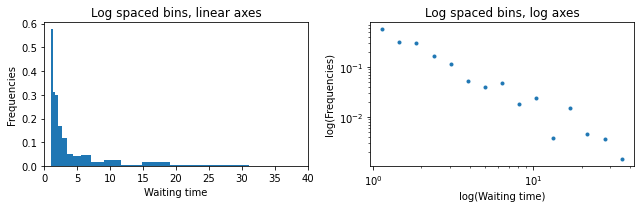

In [178]:
nb =int(np.round(2*len(wt4_r_d)**(1/3)))
bdist4,cdist4 = hist_plot_logbin(wt4_r_d,0,1.6,0,40,nb)

In [179]:
print(max(wt5_r_d))
np.logspace(0,1)

14.730466611459535


array([ 1.        ,  1.04811313,  1.09854114,  1.1513954 ,  1.20679264,
        1.26485522,  1.32571137,  1.38949549,  1.45634848,  1.52641797,
        1.59985872,  1.67683294,  1.75751062,  1.84206997,  1.93069773,
        2.02358965,  2.12095089,  2.22299648,  2.32995181,  2.44205309,
        2.55954792,  2.6826958 ,  2.8117687 ,  2.9470517 ,  3.0888436 ,
        3.23745754,  3.39322177,  3.55648031,  3.72759372,  3.90693994,
        4.09491506,  4.29193426,  4.49843267,  4.71486636,  4.94171336,
        5.17947468,  5.42867544,  5.68986603,  5.96362332,  6.25055193,
        6.55128557,  6.86648845,  7.19685673,  7.54312006,  7.90604321,
        8.28642773,  8.68511374,  9.10298178,  9.54095476, 10.        ])

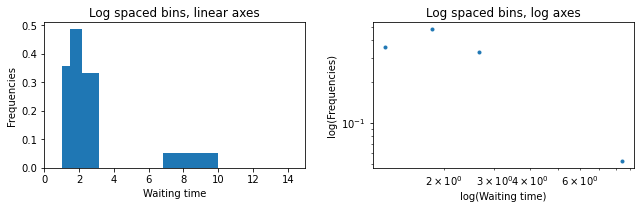

In [180]:
nb =int(np.round(2*len(wt5_r_d)**(1/3)))
bdist5,cdist5 = hist_plot_logbin(wt5_r_d,0,1,0,15,nb)

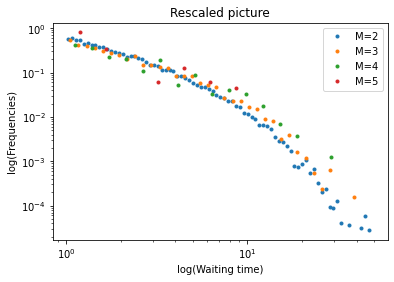

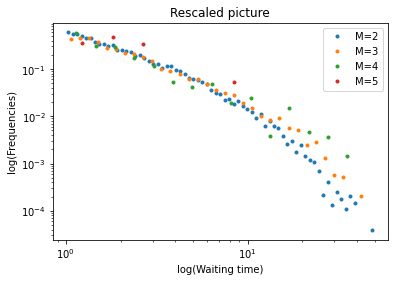

In [181]:
plt.plot(bdist2,cdist2,'.',label='M=2')
plt.plot(bdist3,cdist3,'.',label='M=3')
plt.plot(bdist4,cdist4,'.',label='M=4')
plt.plot(bdist5,cdist5,'.',label='M=5')

plt.xscale('log')
plt.yscale('log')

plt.legend(loc='best')
plt.xlabel('log(Waiting time)')
plt.ylabel('log(Frequencies)')
plt.title('Rescaled picture')
plt.show()
#### PLT ARROW FOR THE FIT REGIME

1. Finish each question
2. Clean the notebook, make it readable
3. Deliver it

**Leon,Joan, Sofia:** 2

**Filippo, Guillermo:** 3-4-5 (-6)

**Make some text lines in order to explain the analysis**

**Correct the dataset: label, values, ecc.**

**Choose the same names for labels**

.Notes:

**Joan**

-histogram of nb of earthquakes on days, on a finer scale

-change of coordinates

**Leon**

-time series of depth

-aftershocks animation #(infer damage radius)

-aftershocks duration

**Filippo/Guillermo**

-check binning and nb bins

-check fits and fits regions

-plot fits w/ data points and error bars

-select plots

-check graphs

**Sofia**

-histogram plots and optimize it

